In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = 'D:\Courses\Fall 19\ELEG 815 Statistical Learning\HW5\FilesHw5'
train_data = pd.read_csv(path+'\DigitsTraining.csv',header=None)
test_data = pd.read_csv(path+'\DigitsTesting.csv',header=None)

In [3]:
def Get_Two_Digits(data):
    dataset = pd.DataFrame()
    for i in range(len(data)):
        if int(data.iloc[i][0]) == 2 or int(data.iloc[i][0]) == 1:
            # https://stackoverflow.com/questions/16597265/appending-to-an-empty-dataframe-in-pandas
            """Pandas doesnt append in place. Have to store in a new variable"""
            dataset = dataset.append(data.iloc[i],ignore_index=True)
    return dataset
raw_training_dataset = Get_Two_Digits(train_data)
raw_testing_dataset = Get_Two_Digits(test_data)

In [4]:
def Extract_features(raw_dataset):
    len_dataset = len(raw_dataset)
    number_of_features = 2
    dataset = np.empty((len_dataset,number_of_features + 1))
    true_labels = np.empty((len_dataset,))
    for index,image_pixels in raw_dataset.iterrows():
        """---------------------- Average Intensity-------------------------"""
        avg_intensity = sum(image_pixels[1:])/len(image_pixels[1:])

        """-----------------------Average Symmetry--------------------------"""
        img = np.array(image_pixels[1:]).reshape((16,16))
        flipped_image = np.fliplr(img)
        flipped_image_pixels = flipped_image.flatten()
        image_pixels = np.array(image_pixels)
        asymmetry = sum(np.absolute(image_pixels[1:] - flipped_image_pixels))/len(image_pixels[1:])
        symmetry = 1 - asymmetry
        dataset[index][0] = 1
        dataset[index][1] = 1 - avg_intensity           # Higher value of intensity means there are more white pixels than black pixels because white = 255 and black = 0
        dataset[index][2] = symmetry
        if int(image_pixels[0]) == 2:                   # Suppose digit 2 has label = -1
            true_labels[index] = -1
        else:
            true_labels[index] = 1                      # Suppose digit 6 has label +1
    return dataset,true_labels

train_dataset,train_true_labels = Extract_features(raw_training_dataset)
test_dataset,test_true_labels = Extract_features(raw_testing_dataset)
print(train_dataset.shape)
print(test_dataset.shape)

(1736, 3)
(462, 3)


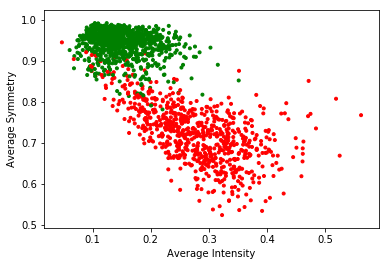

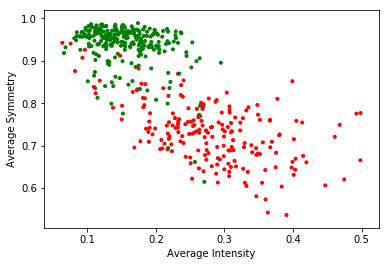

In [5]:
def Set_Colors_Array(true_labels):
    col = [None]*len(true_labels)
    for i in range(len(true_labels)):
        if int(true_labels[i]) == -1:
            col[i] = 'r'
        else:
            col[i] = 'g'
    return col
colors_train = Set_Colors_Array(train_true_labels)
colors_test = Set_Colors_Array(test_true_labels)
def Scatter_Plot(dataset,colors):           # Red = digit 2 and Green = digit 1
    x = dataset[:,1]
    y = dataset[:,2]
    plt.scatter(x,y,c= colors,marker='.')
    plt.xlabel('Average Intensity')
    plt.ylabel('Average Symmetry')
    plt.show()
Scatter_Plot(train_dataset,colors_train)
Scatter_Plot(test_dataset,colors_test)

In [6]:
def Linear_Regression(X,Y):
    XTranspose_X_Inv = np.dot(np.linalg.inv(np.dot(X.T,X)),X.T)
    return np.dot(XTranspose_X_Inv,Y)
W = Linear_Regression(train_dataset,train_true_labels)
print(W)

[-5.89094936 -0.30845908  7.1851853 ]


In [7]:
def Error(dataset,true_labels,W):
    count = 0
    for index,point in enumerate(dataset):
        if np.sign(np.dot(W.T,point)) != true_labels[index]:
            count += 1
    return (count/len(dataset))*100
print('Error of Training Data :',Error(train_dataset,train_true_labels,W))

Error of Training Data : 3.225806451612903


In [8]:
def Test(W,test_dataset,test_true_labels):
    count = 0
    for index,point in enumerate(test_dataset):
        if np.sign(np.dot(W.T,point)) != test_true_labels[index]:
            count += 1
    return (count/len(test_dataset))*100
print('Error of Testing Data :',Test(W,test_dataset,test_true_labels))

Error of Testing Data : 5.844155844155844


# (d) Repeat Pocket Learner for Linear Regression weights

In [9]:
def Pocket_Learner(dataset,test_dataset,test_labels,true_labels,W_init):
    """-----------------------------Pocket Learner Initializations-----------------------------------"""
    W_Pocket = W_init
    #E_in = 50
    iterations = 200
    E_in_list = []
    E_out_list = []
    count = 0
    for index,point in enumerate(dataset):
        if np.sign(np.dot(W_Pocket.T,point)) != true_labels[index]:
            count += 1
    E_in = (count/len(dataset))*100
    """-----------------------------Perceptron Learner Initializations--------------------------------"""
    np.random.seed(1111)
    W_rand = np.random.normal(0,0.0005,(dataset.shape[1],))
    W_rand[0] = 0.1             # bias
    W = W_rand
    print('Intial weight vector W :',W)
    """-----------------------------------------------------------------------------------------------"""
    for iteration in range(iterations):
        for index,point in enumerate(dataset):
            if np.sign(np.dot(W.T,point)) != true_labels[index]:
                W = W + np.dot(true_labels[index],point)
        """------------------------ Error Calculation ------------------------------"""     
        count = 0
        for index,point in enumerate(dataset):
            if np.sign(np.dot(W.T,point)) != true_labels[index]:
                count += 1
        E_t = (count/len(dataset))*100
        cnt = 0
        for index,point in enumerate(test_dataset):
            if np.sign(np.dot(W.T,point)) != test_labels[index]:
                cnt += 1
        E_out = (cnt/len(test_dataset))*100
        if E_t < E_in:
            E_in = E_t
            E_in_list.append(E_t)
            E_out_list.append(E_out)
            W_Pocket = W   
    return W_Pocket,E_in_list,E_out_list  
W_init = W
W_Pocket,E_in,E_out = Pocket_Learner(train_dataset,test_dataset,test_true_labels,train_true_labels,W_init)
print('Final Pocket Weight Vector :',W_Pocket)

Intial weight vector W : [ 0.1        -0.00053649  0.0003951 ]
Final Pocket Weight Vector : [-18.9         -0.83314196  22.29892635]


In [10]:
print('Error of Training Data using W_lin :',Error(train_dataset,train_true_labels,W_Pocket))
print('Error of Testing Data using W_lin :',Test(W_Pocket,test_dataset,test_true_labels))

Error of Training Data using W_lin : 2.6497695852534564
Error of Testing Data using W_lin : 6.493506493506493


200


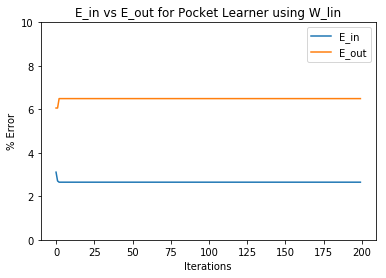

In [11]:
def Plot_Errors(E_in,E_out,title):
    x = [i for i in range(200)]
    last_E_in = E_in[-1]
    if len(E_in) < 200:
        gap = 200 - len(E_in)
        for i in range(gap):
            E_in.append(last_E_in)
    last_E_out = E_out[-1]
    if len(E_out) < 200:
        gap = 200 - len(E_out)
        for i in range(gap):
            E_out.append(last_E_out)
    axes = plt.gca()
    axes.set_ylim([0,10])
    plt.plot(x,E_in)
    plt.plot(x,E_out)
    plt.legend(['E_in','E_out'])
    plt.xlabel('Iterations')
    plt.ylabel('% Error')
    plt.title(title)
    plt.show
Plot_Errors(E_in,E_out,'E_in vs E_out for Pocket Learner using W_lin')
print(len(E_in))

In (d) the training error decreases from 3.2258 to 2.6497 but testing error increases from 5.8441 to  6.4935. Hence our Pocket Learner does not generalize well out of sample when its intial weights are set to weights given by linear regression. Hence Linear Regression preforms better than Pocket Learner as it generalizes well out of sample. This is intuitive because in Linear Regression we get the weights from an exact analytic solution which minimizes the squared error term whereas in Pocket Learner we just try to fit the training data as much as possible with least error which is not going to perform well out of sample.

# (f) Repeat (c) Linear Regression with Additional Feature

In [12]:
def Extract_Additonal_Feature(existing_dataset):
    new_feature = np.empty((len(existing_dataset),))
    new_dataset = np.empty((len(existing_dataset),existing_dataset.shape[1]+1))
    new_dataset[:,:3] = existing_dataset
    for i in range(len(existing_dataset)):
        new_feature[i] = existing_dataset[i][2]**2
        new_dataset[i][3] = new_feature[i]
    return new_dataset
        
new_train_dataset = Extract_Additonal_Feature(train_dataset)
new_test_dataset = Extract_Additonal_Feature(test_dataset)

In [13]:
def Linear_Regression(X,Y):
    XTranspose_X_Inv = np.dot(np.linalg.inv(np.dot(X.T,X)),X.T)
    return np.dot(XTranspose_X_Inv,Y)
W = Linear_Regression(new_train_dataset,train_true_labels)
print(W)

[  5.7895822   -0.3479321  -22.18470203  18.03110353]


In [14]:
print('Error of Training Data with additional feature :',Error(new_train_dataset,train_true_labels,W))
print('Error of Testing Data with additional feature :',Test(W,new_test_dataset,test_true_labels))

Error of Training Data with additional feature : 2.9377880184331797
Error of Testing Data with additional feature : 6.70995670995671


#Error of Training Data with additional feature : 2.9377880184331797
#Error of Testing Data with additional feature : 6.70995670995671